In [1]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    }
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [4]:
agg_strats = ['mean']

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

predictions = m_wrap.get_sub(aggregated=True)

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}


In [5]:
predictions.columns

Index(['building_id', 'hourDayMonthYear', 'isEstimated', 'delta_forecast',
       'date_forecast', 'dayMonthYear', 'monthYear', 'month', 'hour',
       'mean_date_calc', 'mean_absolute_humidity_2m:gm3',
       'mean_air_density_2m:kgm3', 'mean_ceiling_height_agl:m',
       'mean_clear_sky_energy_1h:J', 'mean_clear_sky_rad:W',
       'mean_cloud_base_agl:m', 'mean_dew_or_rime:idx', 'mean_dew_point_2m:K',
       'mean_diffuse_rad:W', 'mean_diffuse_rad_1h:J', 'mean_direct_rad:W',
       'mean_direct_rad_1h:J', 'mean_effective_cloud_cover:p',
       'mean_is_day:idx', 'mean_is_in_shadow:idx', 'mean_msl_pressure:hPa',
       'mean_precip_5min:mm', 'mean_precip_type_5min:idx',
       'mean_pressure_100m:hPa', 'mean_pressure_50m:hPa', 'mean_prob_rime:p',
       'mean_rain_water:kgm2', 'mean_relative_humidity_1000hPa:p',
       'mean_sfc_pressure:hPa', 'mean_sun_azimuth:d', 'mean_sun_elevation:d',
       'mean_super_cooled_liquid_water:kgm2', 'mean_t_1000hPa:K',
       'mean_total_cloud_cover:

# Model 1

In [6]:
agg_strats = ['min','max']
rand_incr = 1
name = 'MinMax'

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(8):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=12,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
0:	learn: 0.1541215	total: 204ms	remaining: 2m 42s
1:	learn: 0.1501101	total: 379ms	remaining: 2m 31s
2:	learn: 0.1459939	total: 493ms	remaining: 2m 11s
3:	learn: 0.1420248	total: 607ms	remaining: 2m
4:	learn: 0.1383327	total: 720ms	remaining: 1m 54s
5:	learn: 0.1348207	total: 851ms	remaining: 1m 52s
6:	learn: 0.1317561	total: 865ms	remaining: 1m 37s
7:	learn: 0.1283824	total: 977ms	remaining: 1m 36s
8:	learn: 0.1252243	total: 1.11s	remaining: 1m 37s
9:	learn: 0.1220848	total: 1.24s	remaining: 1m 37s
10:	learn: 0.1190510	total: 1.35s	remaining: 1m 36s
11:	learn: 0.1161416	total: 1.46s	remaining: 1m 35s
12:	learn: 0.1133316	total: 1.58s	remaining: 1m 35s
13:	learn: 0.1107856	total: 1.71s	remaining: 1m 35s
14:	learn: 0.1081094	total: 1.85s	remaining: 1m 36s
15:	learn: 0.1055359	total: 1.99s	remaining: 1m 37s
16:	learn: 0.1031010	total: 2.1s	remaining: 1m 36s
17:	learn: 0.1007692	total: 2.22s	remaining: 1m 36s

In [ ]:
agg_strats = ['mean','std']
rand_incr = 2
name = 'MeanStd'

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(8):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=12,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
0:	learn: 0.1540231	total: 126ms	remaining: 1m 40s
1:	learn: 0.1499344	total: 257ms	remaining: 1m 42s
2:	learn: 0.1460196	total: 387ms	remaining: 1m 42s
3:	learn: 0.1421422	total: 521ms	remaining: 1m 43s
4:	learn: 0.1384067	total: 648ms	remaining: 1m 43s
5:	learn: 0.1347952	total: 776ms	remaining: 1m 42s
6:	learn: 0.1313040	total: 907ms	remaining: 1m 42s
7:	learn: 0.1279316	total: 1.03s	remaining: 1m 41s
8:	learn: 0.1247194	total: 1.15s	remaining: 1m 40s
9:	learn: 0.1214774	total: 1.28s	remaining: 1m 41s
10:	learn: 0.1186339	total: 1.43s	remaining: 1m 42s
11:	learn: 0.1156809	total: 1.55s	remaining: 1m 42s
12:	learn: 0.1128598	total: 1.68s	remaining: 1m 41s
13:	learn: 0.1101313	total: 1.8s	remaining: 1m 41s
14:	learn: 0.1076019	total: 1.94s	remaining: 1m 41s
15:	learn: 0.1050635	total: 2.06s	remaining: 1m 40s
16:	learn: 0.1025975	total: 2.17s	remaining: 1m 40s
17:	learn: 0.1003246	total: 2.29s	remaining: 1m

In [ ]:
agg_strats = ['mean','std','min','max','00','15','30','45']
rand_incr = 3
name = 'Everything'

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = [],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()


for i in range(8):
    # automatically set types of columns for imputing and oneHotEncoding
    columnTransformer = ColumnTransformer(
        transformers=[
            ('imputer', SimpleImputer(strategy='constant'),impute_features),
            ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',  # Dont drop remaining columns
        n_jobs=-1
    )

    mod = CatBoostRegressor(
        objective='MAE',
        iterations=800,
        depth=12,
        random_seed=i*100+rand_incr,
    )

    model = Pipeline(steps=[
        ('columnTransformer', columnTransformer),
        ('estimator', mod)
    ])


    model.fit(X_train_agg, y_train_agg)
    pred_sub = pd.Series(model.predict(X_sub_agg))
    pred_sub = pd.Series(m_wrap.transform_prediction(pred_sub, X_sub_agg))

    predictions[f'{name}_{i}'] = pred_sub

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
0:	learn: 0.1541062	total: 456ms	remaining: 6m 4s
1:	learn: 0.1498811	total: 916ms	remaining: 6m 5s
2:	learn: 0.1461312	total: 1.41s	remaining: 6m 13s
3:	learn: 0.1422125	total: 1.95s	remaining: 6m 27s
4:	learn: 0.1384419	total: 2.43s	remaining: 6m 27s
5:	learn: 0.1347054	total: 2.96s	remaining: 6m 31s
6:	learn: 0.1312082	total: 3.43s	remaining: 6m 29s
7:	learn: 0.1278774	total: 3.93s	remaining: 6m 28s
8:	learn: 0.1246487	total: 4.49s	remaining: 6m 34s
9:	learn: 0.1215675	total: 4.99s	remaining: 6m 34s
10:	learn: 0.1185209	total: 5.59s	remaining: 6m 40s
11:	learn: 0.1157347	total: 6.16s	remaining: 6m 44s
12:	learn: 0.1129267	total: 6.67s	remaining: 6m 44s
13:	learn: 0.1102384	total: 7.09s	remaining: 6m 38s
14:	learn: 0.1075628	total: 7.59s	remaining: 6m 37s
15:	learn: 0.1051891	total: 8.1s	remaining: 6m 36s
16:	learn: 0.1026931	total: 8.52s	remaining: 6m 32s
17:	learn: 0.1004489	total: 8.95s	remaining: 6m 2

In [ ]:
predictions

,building_id,hourDayMonthYear,isEstimated,delta_forecast,date_forecast,dayMonthYear,monthYear,month,hour,mean_date_calc,mean_absolute_humidity_2m:gm3,mean_air_density_2m:kgm3,mean_ceiling_height_agl:m,mean_clear_sky_energy_1h:J,mean_clear_sky_rad:W,mean_cloud_base_agl:m,mean_dew_or_rime:idx,mean_dew_point_2m:K,mean_diffuse_rad:W,mean_diffuse_rad_1h:J,mean_direct_rad:W,mean_direct_rad_1h:J,mean_effective_cloud_cover:p,mean_elevation:m,mean_fresh_snow_12h:cm,mean_fresh_snow_1h:cm,mean_fresh_snow_24h:cm,mean_fresh_snow_3h:cm,mean_fresh_snow_6h:cm,mean_is_day:idx,mean_is_in_shadow:idx,mean_msl_pressure:hPa,mean_precip_5min:mm,mean_precip_type_5min:idx,mean_pressure_100m:hPa,mean_pressure_50m:hPa,mean_prob_rime:p,mean_rain_water:kgm2,mean_relative_humidity_1000hPa:p,mean_sfc_pressure:hPa,mean_snow_density:kgm3,mean_snow_depth:cm,mean_snow_drift:idx,mean_snow_melt_10min:mm,mean_snow_water:kgm2,mean_sun_azimuth:d,mean_sun_elevation:d,mean_super_cooled_liquid_water:kgm2,mean_t_1000hPa:K,mean_total_cloud_cover:p,mean_visibility:m,mean_wind_speed_10m:ms,mean_wind_speed_u_10m:ms,mean_wind_speed_v_10m:ms,mean_wind_speed_w_1000hPa:ms,mean_GHI,mean_wind_angle,mean_temp*GHI,mean_wind*humidity,mean_sun_height*diff_rad,mean_wind_angle_sin,mean_wind_angle_cos,mean_hour_sin,mean_hour_cos,mean_GHI_daily_mean,mean_GHI_daily_std,mean_effective_cloud_cover_5h_mean,mean_GHI_lag_-1h,mean_GHI_lag_1h,mean_temp*GHI_lag_-1h,mean_temp*GHI_lag_1h,MinMax_0,MinMax_1,MinMax_2,MinMax_3,MinMax_4,MinMax_5,MinMax_6,MinMax_7,MeanStd_0,MeanStd_1,MeanStd_2,MeanStd_3,MeanStd_4,MeanStd_5,MeanStd_6,MeanStd_7,Everything_0,Everything_1,Everything_2,Everything_3,Everything_4,Everything_5,Everything_6,Everything_7
0,a,2023-05-01 00:00:00,1,16.998889,2023-05-01 00:00:00,2023-05-01,2023-05,5,0,2023-04-30 07:00:04,4.325,1.28675,912.700012,0.000000,0.000000,1061.550049,0.0,271.650024,0.000000,0.000000,0.000000,0.000000,74.949997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.674988,0.0,0.0,1000.549988,1006.799988,0.0,0.0,80.275002,1013.099976,NaN,0.0,0.0,0.0,0.0,16.026501,-10.541000,0.000,273.799988,74.949997,29907.500000,3.950,2.100,3.350,0.0,0.000000,0.559798,0.000000,317.087524,0.000000,0.530980,0.847307,0.000000,1.000000,202.039597,198.742325,79.793338,0.000000,NaN,0.000000,NaN,-0.883924,0.386182,-0.219143,-2.420020,-1.996443,0.434407,-0.812059,-0.263169,0.012537,-0.187371,2.808249,-0.039505,-0.006721,-0.604994,-0.413466,0.327134,-0.379284,0.018305,-12.648678,2.570890,7.280856,-9.316525,-0.070631,0.920675
1,a,2023-05-01 01:00:00,1,17.998889,2023-05-01 01:00:00,2023-05-01,2023-05,5,1,2023-04-30 07:00:04,4.275,1.28600,1482.099976,0.000000,0.000000,1075.100098,0.0,271.450012,0.000000,0.000000,0.000000,0.000000,77.474998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.150024,0.0,0.0,1000.049988,1006.299988,0.0,0.0,79.824997,1012.599976,NaN,0.0,0.0,0.0,0.0,30.497250,-7.894500,0.000,273.799988,77.474998,29519.074219,3.825,1.925,3.300,0.0,0.000000,0.528019,0.000000,305.339996,0.000000,0.503799,0.863766,0.258819,0.965926,202.039597,198.742325,76.806456,0.000000,0.000000,0.000000,0.000000,2.647394,-0.070015,-0.010982,-2.726444,-2.019442,-2.597519,-0.903980,1.320695,0.011780,-0.266064,0.182029,-0.030734,-0.264045,0.143427,-14.090723,-4.678421,-10.642518,-5.821581,-13.407167,2.751357,-0.116988,2.485306,-0.287152,-1.022347
2,a,2023-05-01 02:00:00,1,18.998889,2023-05-01 02:00:00,2023-05-01,2023-05,5,2,2023-04-30 07:00:04,4.150,1.28375,1791.300049,0.000000,0.000000,1200.400024,0.0,271.049988,0.000000,0.000000,0.000000,0.000000,88.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1012.674988,0.0,0.0,999.500000,1005.799988,0.0,0.0,78.000000,1012.049988,NaN,0.0,0.0,0.0,0.0,44.517250,-3.815500,0.000,273.849976,88.099998,31009.125000,3.650,1.750,3.200,0.0,0.000000,0.500362,0.000000,284.739990,0.000000,0.479708,0.877346,0.500000,0.866025,202.039597,198.742325,75.134157,11.475000,0.000000,3143.002441,0.000000,3.855980,-3.829964,-6.474369,-2.974095,-1.413605,3.966994,0.246502,9.483434,1.817413,-4.999693,-3.270749,0.460305,-

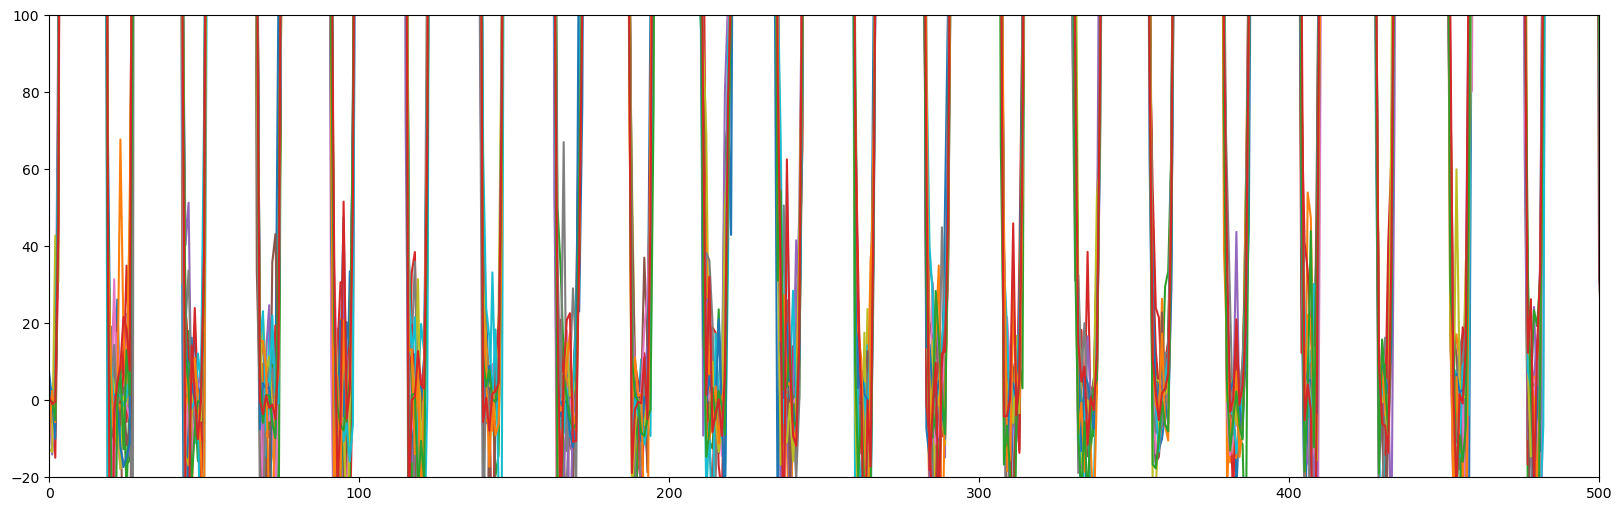

In [ ]:
pred_only_pred = predictions.iloc[:,-24:]
plt.figure(figsize=(20,6))
plt.xlim(0,500)
plt.ylim(-20,100)
plt.plot(pred_only_pred);

In [ ]:
predictions

,building_id,hourDayMonthYear,isEstimated,delta_forecast,date_forecast,dayMonthYear,monthYear,month,hour,mean_date_calc,mean_absolute_humidity_2m:gm3,mean_air_density_2m:kgm3,mean_ceiling_height_agl:m,mean_clear_sky_energy_1h:J,mean_clear_sky_rad:W,mean_cloud_base_agl:m,mean_dew_or_rime:idx,mean_dew_point_2m:K,mean_diffuse_rad:W,mean_diffuse_rad_1h:J,mean_direct_rad:W,mean_direct_rad_1h:J,mean_effective_cloud_cover:p,mean_elevation:m,mean_fresh_snow_12h:cm,mean_fresh_snow_1h:cm,mean_fresh_snow_24h:cm,mean_fresh_snow_3h:cm,mean_fresh_snow_6h:cm,mean_is_day:idx,mean_is_in_shadow:idx,mean_msl_pressure:hPa,mean_precip_5min:mm,mean_precip_type_5min:idx,mean_pressure_100m:hPa,mean_pressure_50m:hPa,mean_prob_rime:p,mean_rain_water:kgm2,mean_relative_humidity_1000hPa:p,mean_sfc_pressure:hPa,mean_snow_density:kgm3,mean_snow_depth:cm,mean_snow_drift:idx,mean_snow_melt_10min:mm,mean_snow_water:kgm2,mean_sun_azimuth:d,mean_sun_elevation:d,mean_super_cooled_liquid_water:kgm2,mean_t_1000hPa:K,mean_total_cloud_cover:p,mean_visibility:m,mean_wind_speed_10m:ms,mean_wind_speed_u_10m:ms,mean_wind_speed_v_10m:ms,mean_wind_speed_w_1000hPa:ms,mean_GHI,mean_wind_angle,mean_temp*GHI,mean_wind*humidity,mean_sun_height*diff_rad,mean_wind_angle_sin,mean_wind_angle_cos,mean_hour_sin,mean_hour_cos,mean_GHI_daily_mean,mean_GHI_daily_std,mean_effective_cloud_cover_5h_mean,mean_GHI_lag_-1h,mean_GHI_lag_1h,mean_temp*GHI_lag_-1h,mean_temp*GHI_lag_1h,MinMax_0,MinMax_1,MinMax_2,MinMax_3,MinMax_4,MinMax_5,MinMax_6,MinMax_7,MeanStd_0,MeanStd_1,MeanStd_2,MeanStd_3,MeanStd_4,MeanStd_5,MeanStd_6,MeanStd_7,Everything_0,Everything_1,Everything_2,Everything_3,Everything_4,Everything_5,Everything_6,Everything_7
0,a,2023-05-01 00:00:00,1,16.998889,2023-05-01 00:00:00,2023-05-01,2023-05,5,0,2023-04-30 07:00:04,4.325,1.28675,912.700012,0.000000,0.000000,1061.550049,0.0,271.650024,0.000000,0.000000,0.000000,0.000000,74.949997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.674988,0.0,0.0,1000.549988,1006.799988,0.0,0.0,80.275002,1013.099976,NaN,0.0,0.0,0.0,0.0,16.026501,-10.541000,0.000,273.799988,74.949997,29907.500000,3.950,2.100,3.350,0.0,0.000000,0.559798,0.000000,317.087524,0.000000,0.530980,0.847307,0.000000,1.000000,202.039597,198.742325,79.793338,0.000000,NaN,0.000000,NaN,-0.883924,0.386182,-0.219143,-2.420020,-1.996443,0.434407,-0.812059,-0.263169,0.012537,-0.187371,2.808249,-0.039505,-0.006721,-0.604994,-0.413466,0.327134,-0.379284,0.018305,-12.648678,2.570890,7.280856,-9.316525,-0.070631,0.920675
1,a,2023-05-01 01:00:00,1,17.998889,2023-05-01 01:00:00,2023-05-01,2023-05,5,1,2023-04-30 07:00:04,4.275,1.28600,1482.099976,0.000000,0.000000,1075.100098,0.0,271.450012,0.000000,0.000000,0.000000,0.000000,77.474998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1013.150024,0.0,0.0,1000.049988,1006.299988,0.0,0.0,79.824997,1012.599976,NaN,0.0,0.0,0.0,0.0,30.497250,-7.894500,0.000,273.799988,77.474998,29519.074219,3.825,1.925,3.300,0.0,0.000000,0.528019,0.000000,305.339996,0.000000,0.503799,0.863766,0.258819,0.965926,202.039597,198.742325,76.806456,0.000000,0.000000,0.000000,0.000000,2.647394,-0.070015,-0.010982,-2.726444,-2.019442,-2.597519,-0.903980,1.320695,0.011780,-0.266064,0.182029,-0.030734,-0.264045,0.143427,-14.090723,-4.678421,-10.642518,-5.821581,-13.407167,2.751357,-0.116988,2.485306,-0.287152,-1.022347
2,a,2023-05-01 02:00:00,1,18.998889,2023-05-01 02:00:00,2023-05-01,2023-05,5,2,2023-04-30 07:00:04,4.150,1.28375,1791.300049,0.000000,0.000000,1200.400024,0.0,271.049988,0.000000,0.000000,0.000000,0.000000,88.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1012.674988,0.0,0.0,999.500000,1005.799988,0.0,0.0,78.000000,1012.049988,NaN,0.0,0.0,0.0,0.0,44.517250,-3.815500,0.000,273.849976,88.099998,31009.125000,3.650,1.750,3.200,0.0,0.000000,0.500362,0.000000,284.739990,0.000000,0.479708,0.877346,0.500000,0.866025,202.039597,198.742325,75.134157,11.475000,0.000000,3143.002441,0.000000,3.855980,-3.829964,-6.474369,-2.974095,-1.413605,3.966994,0.246502,9.483434,1.817413,-4.999693,-3.270749,0.460305,-

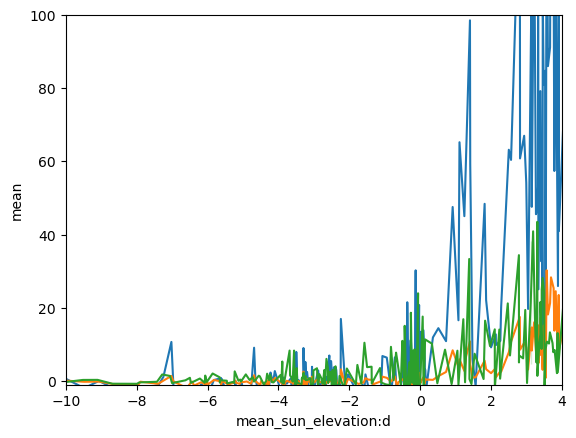

In [ ]:
predictions['mean'] = pred_only_pred.mean(axis=1)
plt.xlim(-10,4)
plt.ylim(-1,100)
sns.lineplot(data=predictions, x='mean_sun_elevation:d', y='mean', hue='building_id', legend=False);

In [ ]:
predictions.columns

Index(['building_id', 'hourDayMonthYear', 'isEstimated', 'delta_forecast',
       'date_forecast', 'dayMonthYear', 'monthYear', 'month', 'hour',
       'mean_date_calc', 'mean_absolute_humidity_2m:gm3',
       'mean_air_density_2m:kgm3', 'mean_ceiling_height_agl:m',
       'mean_clear_sky_energy_1h:J', 'mean_clear_sky_rad:W',
       'mean_cloud_base_agl:m', 'mean_dew_or_rime:idx', 'mean_dew_point_2m:K',
       'mean_diffuse_rad:W', 'mean_diffuse_rad_1h:J', 'mean_direct_rad:W',
       'mean_direct_rad_1h:J', 'mean_effective_cloud_cover:p',
       'mean_elevation:m', 'mean_fresh_snow_12h:cm', 'mean_fresh_snow_1h:cm',
       'mean_fresh_snow_24h:cm', 'mean_fresh_snow_3h:cm',
       'mean_fresh_snow_6h:cm', 'mean_is_day:idx', 'mean_is_in_shadow:idx',
       'mean_msl_pressure:hPa', 'mean_precip_5min:mm',
       'mean_precip_type_5min:idx', 'mean_pressure_100m:hPa',
       'mean_pressure_50m:hPa', 'mean_prob_rime:p', 'mean_rain_water:kgm2',
       'mean_relative_humidity_1000hPa:p', 'mean_s

In [ ]:
predictions['mean'] = predictions['mean'].clip(0)
predictions.loc[predictions['mean_sun_elevation:d'] <-1,'mean'] = 0

In [ ]:
predictions['mean'].to_csv('catBoost_ensemble_12_new5h_8rands_cleanX.csv', index=True)

In [ ]:
cat = pd.read_csv('submission_files/151_90043_feature_extraction2_scaled_tuned_depth13.csv')['prediction'].to_list()

predictions.append(cat)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

data_root = 'https://autogluon.s3.amazonaws.com/datasets/Inc/'
train_data = TabularDataset(data_root + 'train.csv')
test_data = TabularDataset(data_root + 'test.csv')

predictor = TabularPredictor(label='class').fit(train_data=train_data)
predictions = predictor.predict(test_data)

# Ideas
Bagging:
    - building
    - hour / sun elevation
    - (sunny day)
Stacking
    - xgboost, random forest, catboost, lightgbm
    - different aggregations
        - max, min
        - time values
        - mean, std
        - (everything)
    - random seed

# Combine Predictions

In [ ]:


predictions

array_preds = np.array(predictions)
predictions_mean = pd.Series(np.average(array_preds,axis=0))

In [ ]:
predictions_mean.loc[X_sub_agg['min_sun_elevation:d'] < -1] = 0

predictions_mean.to_csv('submission_files/ensemble.csv',index=True)

In [ ]:

m_wrap.y_pred_to_csv(predictions_mean, X_sub_agg, is_aggregated=True,name='ensemble.csv',sun_el_thr=-5)

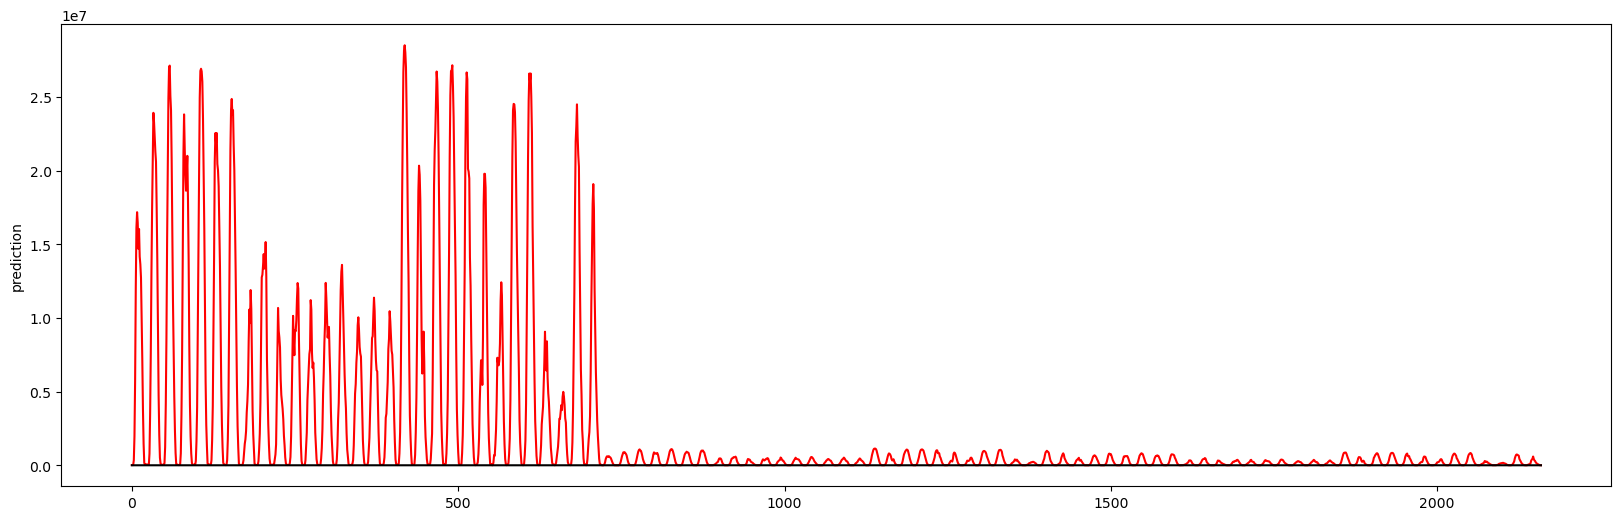

KeyError: 'hourDayMonthYear'

In [ ]:
m_wrap.plot_yPredSub_vs_submission(predictions_mean, X_sub_agg)
m_wrap.y_pred_to_csv(predictions_mean,X_train_agg,True,'building_bagging.csv',1)

In [ ]:
predictions_mean

0    274.467289
dtype: float64